In [1]:
import numpy as np
import pandas as pd
import re
import math
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, font_size=10, fig_size=(12,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    plt.rcParams.update({'font.size': font_size})
    fig, ax = plt.subplots(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Load and Trim Datasets
##Loads data and trims tuples down to correct 2 hour time period

In [2]:

def load_dataset(path):
    out_data = pd.DataFrame()
    for sub_dir in os.listdir(path):
        temp_path = os.path.join(path, sub_dir)
        temp_path = os.path.join(temp_path, "log_tcp_complete")
#        print(temp_path)
        if os.path.isfile(temp_path): 
#            print('1')
#            temp_data = read_in_file(temp_path)
            temp_data = pd.read_csv(temp_path, delimiter= '\s', index_col=False)
            temp_data.shape
            out_data = out_data.append(temp_data) 
        #np.concatenate((out_data, temp_data))
#    return 
    df = out_data
    #load data
#def trim_dataset(df):

    #create timestamp    
    df['t_first']=df['first:29'].astype('float').astype("datetime64[ms]")
    df['t_last']=df['last:30'].astype('float').astype("datetime64[ms]")

    #find start/end time
    t_start = df.t_first.min()
    t_end = t_start+ pd.Timedelta(hours=2)
    t_max = df.t_last.max()

    #trim data after test complete (tstat ran too long in bash shell)    
    df = df[(df['t_first'] >= t_start) & (df['t_last'] < t_end)]
#    df = df.values

    df.drop(columns=['t_first', 't_last'])
    df.drop(df.index[0])

#    csv = get_data_row(df.to_csv( index = False, sep = " "))

    return df

### Load Label Indexes
This chunk loads a file that contains the labels we want to load from the datasets as well as their indicies.

In [3]:
infile = open("tstat_labels_indexes.txt" ,'r')
data_field_list = []
for line in infile.readlines():
    if ":" in line:
        data_field = str(re.search('%s(.*)%s' % ("\"", "\""), line).group(1))
        index = int(re.search('%s(.*)%s' % (":", ","), line).group(1))
        data_field_list.append((data_field, index))

index_to_key_dict = {}
key_to_index_dict = {}
data_field_labels = []
for data_field, index in data_field_list:
    key_to_index_dict[data_field] = index
    index_to_key_dict[index] = data_field
    data_field_labels.append(data_field)
    
len(data_field_list)

FileNotFoundError: [Errno 2] No such file or directory: 'tstat_labels_indexes.txt'

### Read in a dataset file

In [ ]:
def read_in_file(input):
    entries = []
    labels = None
    for i, line in enumerate(input):
        print(row)
        row = get_data_row(line)
        row = clean_data_row(row)
        if row != []:
            entries.append(row)
    entries = np.array(entries)
    return entries

### Get data row
Called by the read in file function. Loads a single line from the dataset files. Super inefficient, but only loads labels which are in the data field list. 

In [ ]:
def get_data_row(line):
    global index_to_key_dict
#    print(line)
    row = []
    labels = []
    c_pkt_cnt = 0
    s_pkt_cnt = 0
    c_bytes_cnt = 0
    s_bytes_cnt = 0
    for data_field, index in data_field_list:
        if data_field == "client_pkt_cnt":
            try:
                c_pkt_cnt = line[index]
                c_pkt_cnt = max(float(c_pkt_cnt), 1)
            except:
                c_pkt_cnt = 1
            #if c_pkt_cnt < 32:
            #    return []
        elif data_field == "serv_pkt_cnt":
            try:
                s_pkt_cnt = line[index]
                s_pkt_cnt = max(float(s_pkt_cnt), 1)
            except:
                s_pkt_cnt = 1
        elif data_field == "client_bytes_cnt":
            try:
                c_bytes_cnt = line[index]
                c_bytes_cnt = max(float(c_bytes_cnt), 1)
            except:
                c_bytes_cnt = 1
        elif data_field == "serv_bytes_cnt":
            try:
                s_bytes_cnt = line[index]
                s_bytes_cnt = max(float(s_bytes_cnt), 1)
            except:
                s_bytes_cnt = 1
                
    for data_field, index in data_field_list:
        try:
            val = line[index]
            val = float(val)
        except:
            val = 0
        if data_field in ["client_pkt_cnt", "client_rst_cnt", "client_ack_cnt", "client_pkt_data", "client_pkt_retx",
                         "client_syn_cnt", "client_fin_cnt", "client_pkt_retx"]:
            val /= c_pkt_cnt
        elif data_field in ["client_bytes_uniq", "client_bytes_cnt", "client_bytes_retx"]:
            val /= c_bytes_cnt
        elif data_field in ["serv_pkt_cnt", "serv_rst_cnt", "serv_ack_cnt", "serv_ack_pck_cnt", "serv_pkts_data", 
                            "serv_pkts_retx", "serv_syn_cnt", "serv_fin_cnt"]:
            val /= s_pkt_cnt
        elif data_field in ["serv_bytes_uniq", "serv_btyes_cnt", "serv_pkts_retx"]:
            val /= s_bytes_cnt
        row.append(val)    
    return row

### Clean data row
Not implemented

In [ ]:
def clean_data_row(in_row):
    global index_to_key_dict, key_to_index_dict

    for data_field, index in data_field_list:
        if math.isnan(in_row[index]):
            try:
                in_row[index] == 0
                
            except:
                print('err')


    
    return in_row

### Get dataset
Loads all files from a directory

In [ ]:
def get_dataset(path):
    print(path)
    temp_data = load_dataset(path)
    temp_data = temp_data.drop(['t_first', 't_last'], axis=1)
#csv = (temp_data.to_csv( index = False, sep = " "))
#entries = []
#lines = csv.splitlines()

    entries = []

    temp_data = temp_data.values
    for row in temp_data:
        myRow = get_data_row(row)
        myRow= [float(i) for i in myRow]

#        myRow = clean_data_row(myRow)
        entries.append(myRow)

    entries = np.array(entries)

    return entries

    # add pandas to list and row algo

#pd.DataFrame(temp_data)
#print("output::", csv)

In [ ]:

temp_data = get_dataset("./normal")

### Load all datasets
Load all datasets
Create numerical lables for each class, and a different set of labels for each subclass.

In [4]:
normal = get_dataset("./normal")
corr_01 = get_dataset("./corrupt_0.1perc")
corr_05 = get_dataset("./corrupt_0.5perc")
corr_10 = get_dataset("./corrupt_1.0perc")
delay_1_1 = get_dataset("./delay_1_var_1")
delay_5_2 = get_dataset("./delay_5_var_2")
delay_10_5 = get_dataset("./delay_10_var_5")
delay_25_20 = get_dataset("./delay_25_var_20")
dup_1 = get_dataset("./dup-1-p")
dup_2 = get_dataset("./dup_2perc")

normal = np.nan_to_num(normal)
corr_01 = np.nan_to_num(corr_01)
corr_05 =  np.nan_to_num(corr_05)
corr_10 = np.nan_to_num(corr_10)
delay_1_1 = np.nan_to_num(delay_1_1)
delay_5_2 = np.nan_to_num(delay_5_2)
delay_10_5 = np.nan_to_num(delay_10_5)
delay_25_20 = np.nan_to_num(delay_25_20)
dup_1 = np.nan_to_num(dup_1)
dup_2 = np.nan_to_num(dup_2)



NameError: name 'get_dataset' is not defined

In [5]:

all_data = np.concatenate((normal,
                           corr_01, corr_05, corr_10,
                           delay_1_1, delay_5_2,delay_10_5,delay_25_20))

NameError: name 'normal' is not defined

In [6]:

all_data = np.concatenate((normal,
                           corr_01, corr_05, corr_10,
                           delay_1_1, delay_5_2,delay_10_5,delay_25_20))

NameError: name 'normal' is not defined

In [7]:
all_data = np.nan_to_num(all_data)
all_data = StandardScaler().fit_transform(all_data)

NameError: name 'all_data' is not defined

In [24]:
all_data.shape


(21576, 89)

In [25]:
a_labels  = np.ones(len(normal  ))    *1
b_labels  = np.ones(len(corr_01  ))   *2
c_labels  = np.ones(len(corr_05  ))   *2
d_labels  = np.ones(len(corr_10  ))   *2
e_labels  = np.ones(len(delay_1_1))   *3
f_labels  = np.ones(len(delay_5_2))   *3
g_labels  = np.ones(len(delay_10_5))  *3
h_labels  = np.ones(len(delay_25_20)) *3
anom_type_data_labels = np.concatenate((a_labels, b_labels, c_labels, d_labels, e_labels,
                                        f_labels, g_labels, h_labels,))


In [26]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=0)



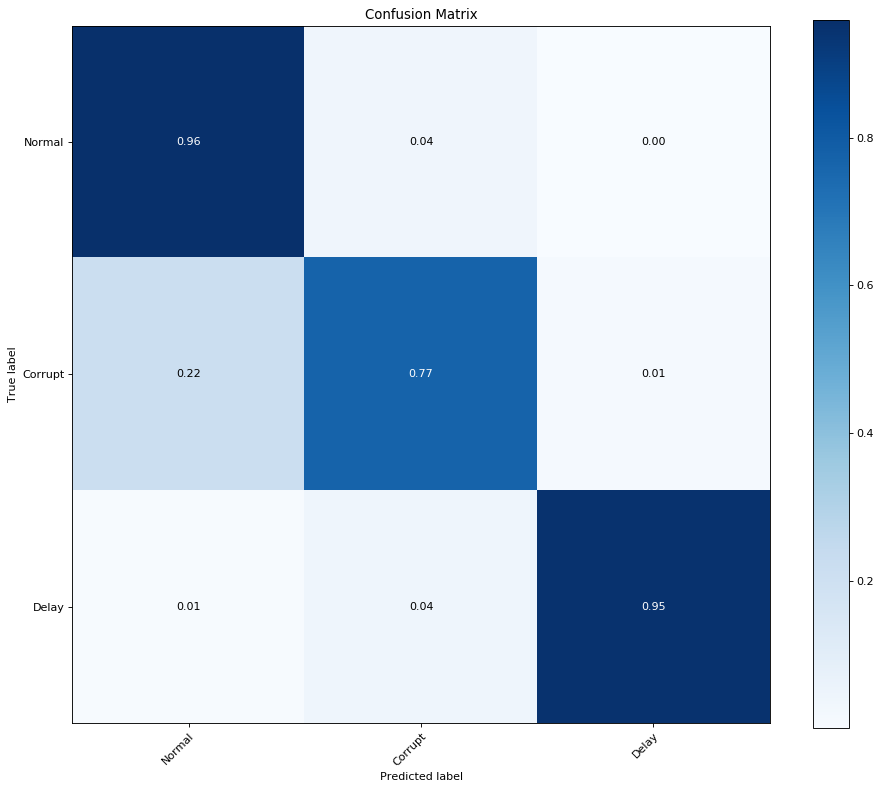

Total Error Count :  1169
Normal Class Error Rate :  9.37178166838311 %
Total Error Rate :  12.03913491246138 %
Total Errors 1169
False Positives  3.213182286302781 %
False Negatives  8.8259526261586 %


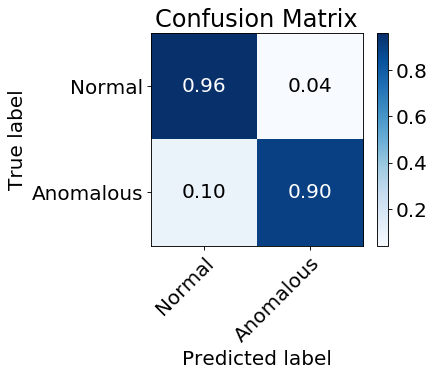

In [27]:
clf = svm.SVC(kernel='linear', gamma =0.1, max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1
        # if the predicted and test labels are in the same class of data
        elif predicted_labels[i] in [2] and test_labels[i] in [2]:
            same_class_error += 1
        elif predicted_labels[i] in [3] and test_labels[i] in [3]:
            same_class_error += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

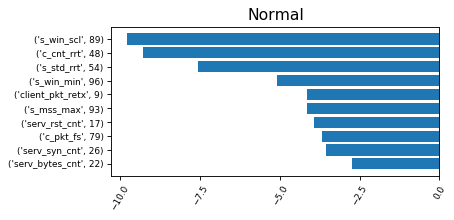

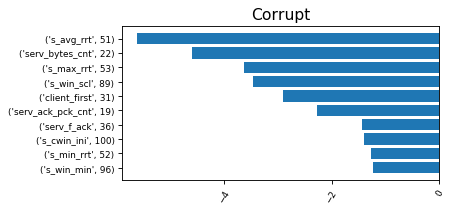

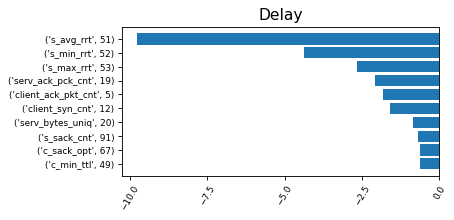

In [28]:
def f_importances(coef, names, title):
    fig=plt.figure(figsize=(6, 3), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title, fontsize=14)
    temp_sorted_rows = []
    for i,co in enumerate(coef):
        temp_sorted_rows.append((names[i],co))
    temp_sorted_rows = sorted(temp_sorted_rows, key=lambda x: x[1])
    temp_names = []
    temp_coefs = []
    for i, (name, co) in enumerate(temp_sorted_rows):
        if i < 10:
            temp_names.append(name)
            temp_coefs.append(co)
    temp_names.reverse()
    temp_coefs.reverse()
    plt.barh(range(len(temp_names)), temp_coefs, align='center')
    plt.yticks(range(len(temp_names)), temp_names, fontsize=8)7
    plt.xticks(fontsize=8, rotation=60)
    plt.tight_layout()
    plt.savefig(str(title)+"_field_imp", format="png")
    plt.show()

for i in range(len(class_names)):
    f_importances(clf.coef_[i], data_field_list, class_names[i])

In [29]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=1)


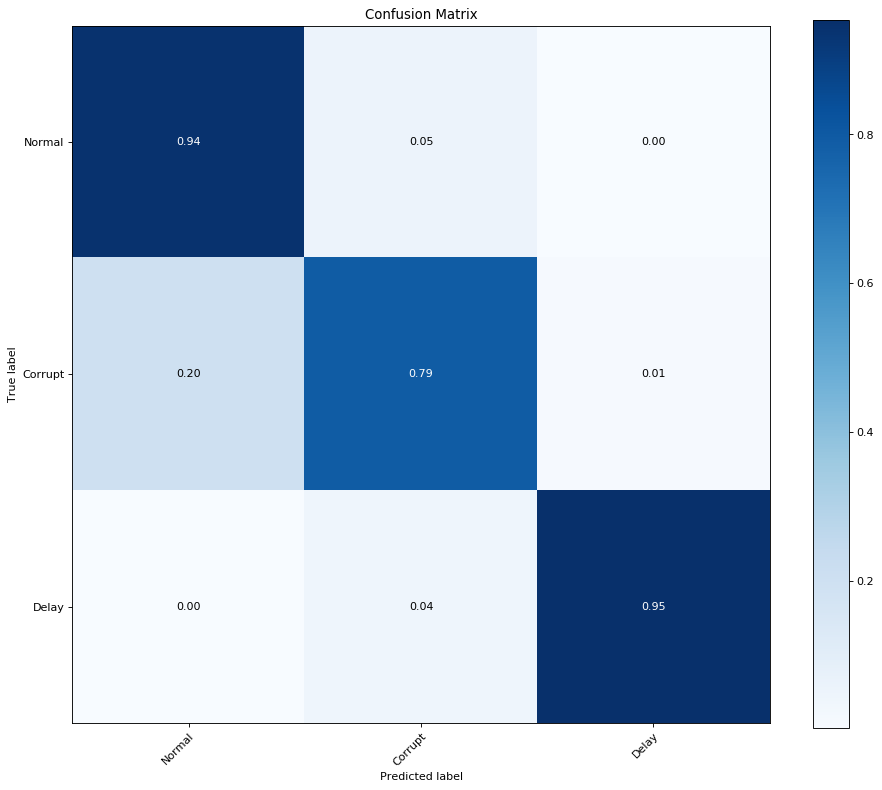

Total Error Count :  1090
Normal Class Error Rate :  8.753861997940268 %
Total Error Rate :  11.225540679711637 %
Total Errors 1090
False Positives  3.2234809474768285 %
False Negatives  8.002059732234809 %


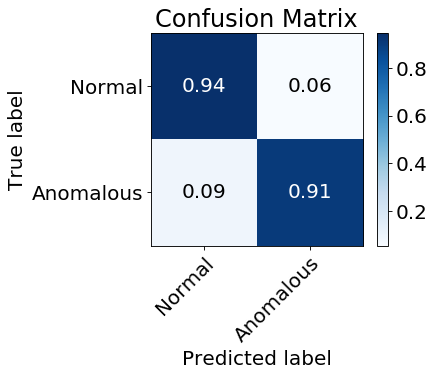

In [30]:
clf = svm.SVC(kernel='linear', gamma =0.1, max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

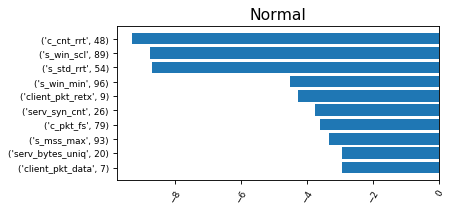

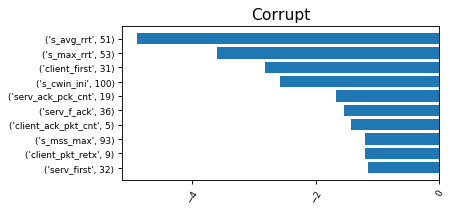

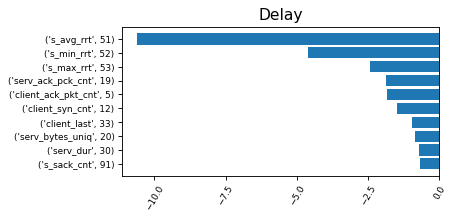

In [31]:
def f_importances(coef, names, title):
    fig=plt.figure(figsize=(6, 3), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title, fontsize=14)
    temp_sorted_rows = []
    for i,co in enumerate(coef):
        temp_sorted_rows.append((names[i],co))
    temp_sorted_rows = sorted(temp_sorted_rows, key=lambda x: x[1])
    temp_names = []
    temp_coefs = []
    for i, (name, co) in enumerate(temp_sorted_rows):
        if i < 10:
            temp_names.append(name)
            temp_coefs.append(co)
    temp_names.reverse()
    temp_coefs.reverse()
    plt.barh(range(len(temp_names)), temp_coefs, align='center')
    plt.yticks(range(len(temp_names)), temp_names, fontsize=8)
    plt.xticks(fontsize=8, rotation=60)
    plt.tight_layout()
    plt.savefig(str(title)+"_field_imp", format="png")
    plt.show()

for i in range(len(class_names)):
    f_importances(clf.coef_[i], data_field_list, class_names[i])

In [32]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=2)

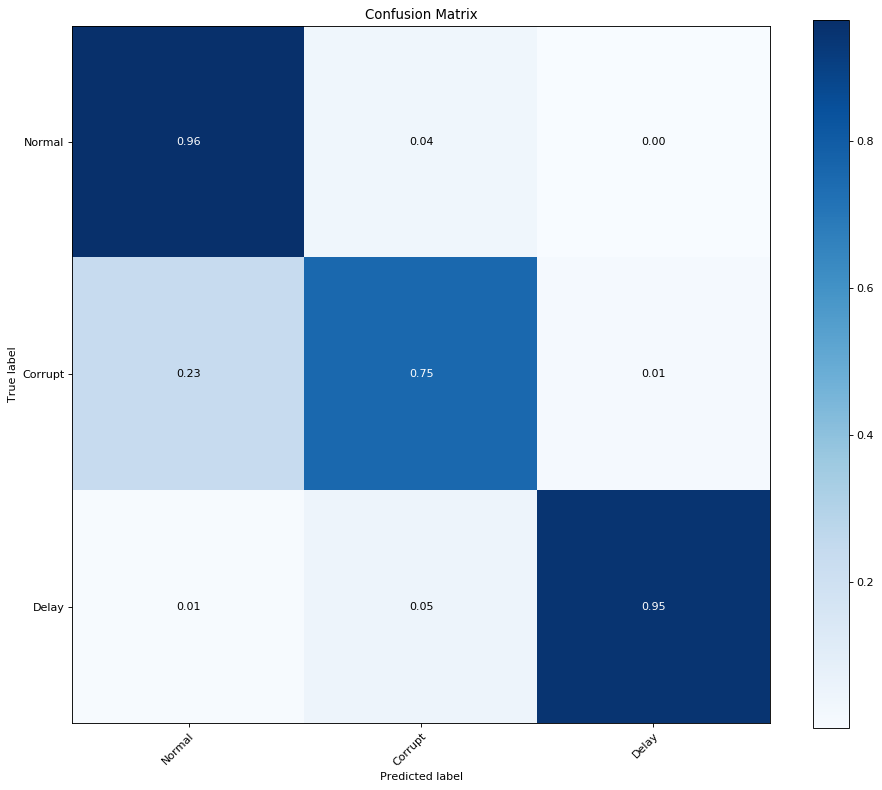

Total Error Count :  1222
Normal Class Error Rate :  9.855818743563336 %
Total Error Rate :  12.58496395468589 %
Total Errors 1222
False Positives  3.213182286302781 %
False Negatives  9.37178166838311 %


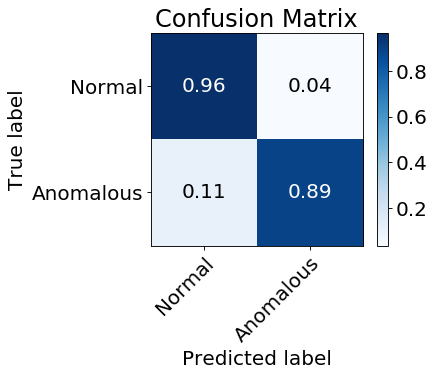

In [33]:
clf = svm.SVC(kernel='linear', gamma =0.00001
              , max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [34]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=3)

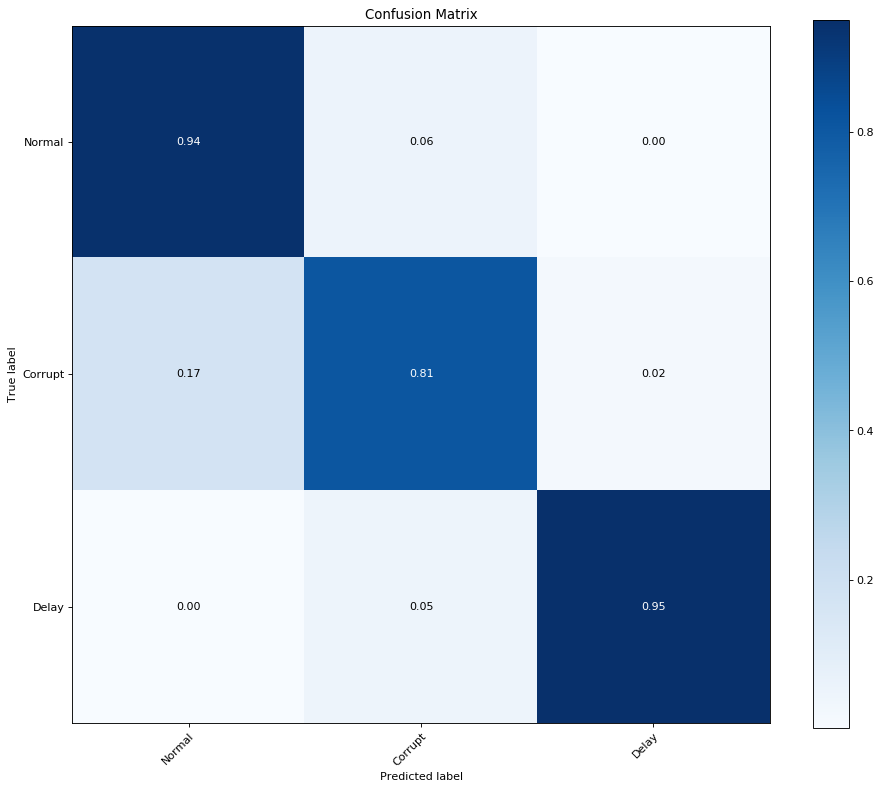

Total Error Count :  1024
Normal Class Error Rate :  7.672502574665294 %
Total Error Rate :  10.545829042224511 %
Total Errors 1024
False Positives  3.6560247167868174 %
False Negatives  6.889804325437693 %


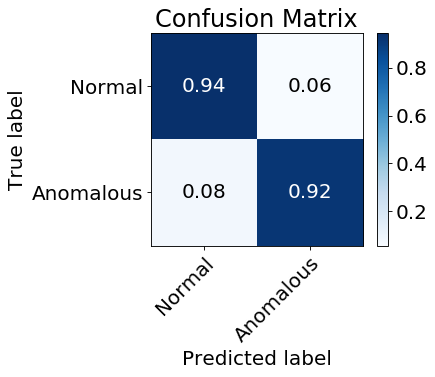

In [35]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay"]
plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [36]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=4)


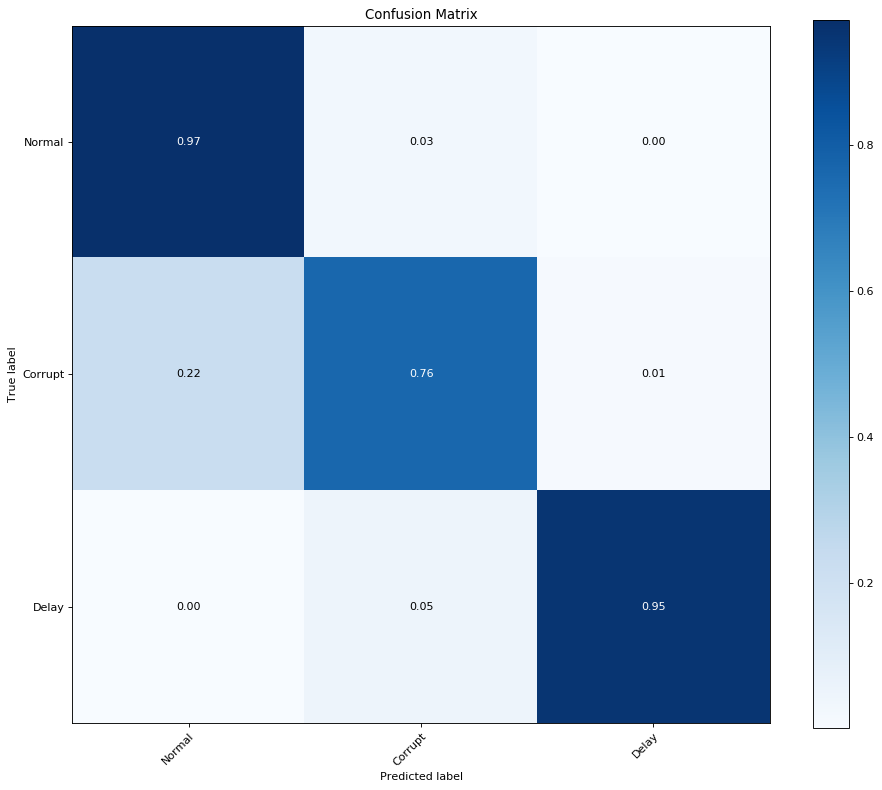

Total Error Count :  1182
Normal Class Error Rate :  9.495365602471677 %
Total Error Rate :  12.173017507723996 %
Total Errors 1182
False Positives  3.0690010298661172 %
False Negatives  9.10401647785788 %


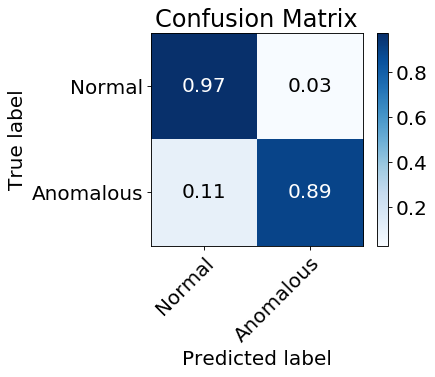

In [37]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay"]
plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [38]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=5)


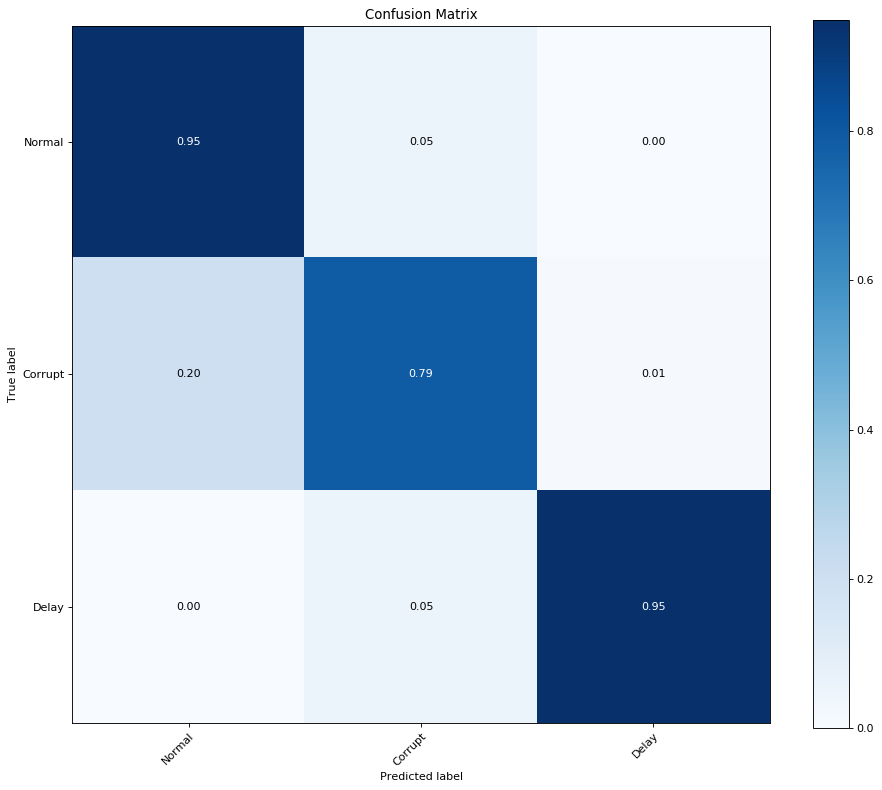

Total Error Count :  1118
Normal Class Error Rate :  8.650875386199793 %
Total Error Rate :  11.513903192584964 %
Total Errors 1118
False Positives  3.553038105046344 %
False Negatives  7.96086508753862 %


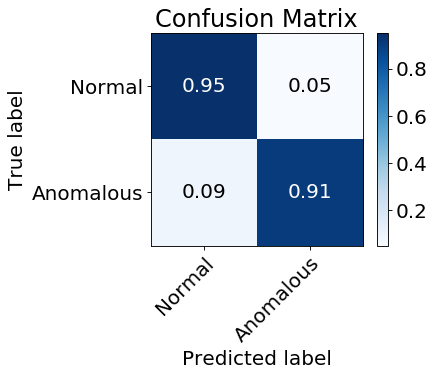

In [39]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay"]
plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [40]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=6 )


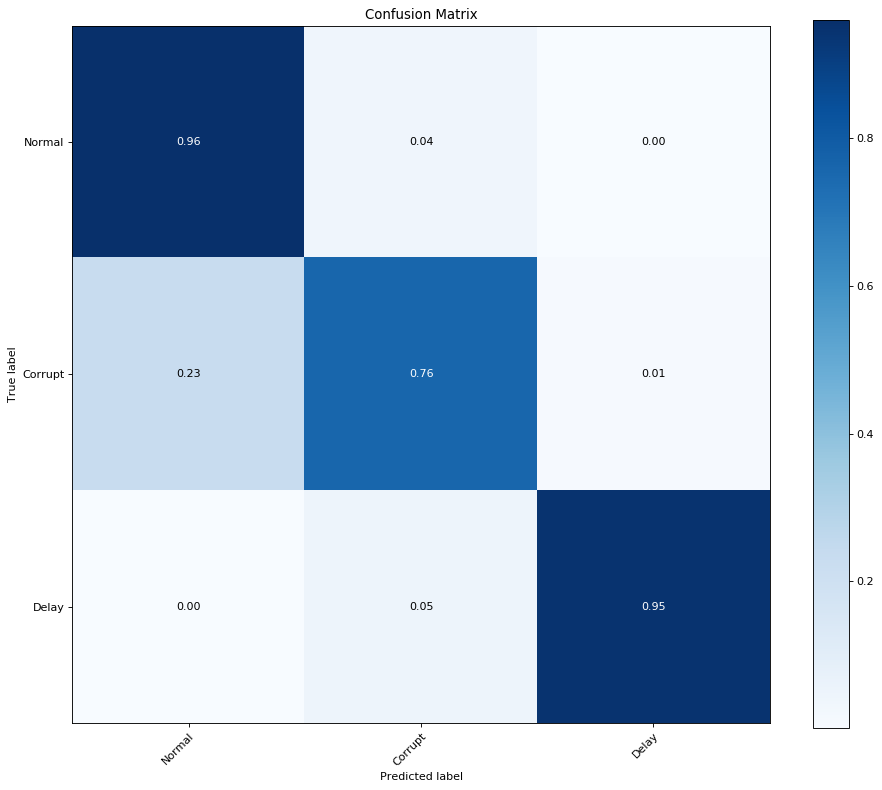

Total Error Count :  1204
Normal Class Error Rate :  9.773429454170959 %
Total Error Rate :  12.399588053553039 %
Total Errors 1204
False Positives  3.1513903192584967 %
False Negatives  9.248197734294541 %


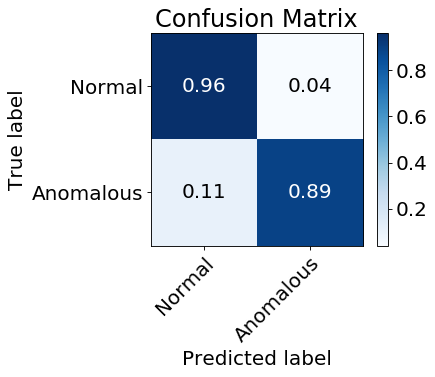

In [41]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay"]
plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()